In [8]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np

In [9]:
user_base = pd.read_csv('bases/users.csv')
task_base = pd.read_csv('bases/tasks.csv')
aloc_base = pd.read_csv('bases/alocacao.csv')

In [10]:
task_base.columns

Index(['id', 'name', 'starts_at', 'ends_at', 'actual_starts_at',
       'actual_ends_at'],
      dtype='object')

In [11]:
task_base.drop(['starts_at','actual_starts_at'], axis=1, inplace=True)

In [12]:
aloc_base.columns

Index(['user_id', 'task_id', 'percentage'], dtype='object')

In [13]:
import numpy as np
def gerar_valores_normais(media, desvio_padrao, tamanho):
    valores_normais = np.random.normal(loc=media, scale=desvio_padrao, size=tamanho)
    return valores_normais

In [14]:
# task_base['delay'] = 0
# count = 0
# max_year_act = 0
# max_year_end = 0
# for index in task_base.index:
#     ends_at = datetime.strptime(task_base['ends_at'][index][:10], '%Y-%m-%d')
    
#     if ends_at.year > 2023:
#         new_year = 2000 + ends_at.year % 23
#         ends_at = ends_at.replace(year=new_year)

#     delay = 30 - int(gerar_valores_normais(60, 5, 1))
#     actual_end = ends_at + timedelta(days=delay)
    
#     task_base['ends_at'][index] = datetime.strftime(ends_at, '%Y-%m-%d')
#     task_base['actual_ends_at'][index] = datetime.strftime(actual_end, '%Y-%m-%d')


#     delay = (ends_at - actual_end)
#     task_base['delay'][index] = delay.days
#     count += 1
#     # if count % 100 == 0:
#     #     print(f'feito {count} de {len(task_base)}')

In [15]:
task_base.fillna('2026-12-31 00:00:00', inplace=True)

***RODAR A PARTIR DAKI***

In [16]:
task_base['delay'] = 0
for index in task_base.index:
    if type(task_base['actual_ends_at'][index]) == float:
        print("Error linha: ", index)
        break
    ends_at = datetime.strptime(task_base['ends_at'][index][:10], '%Y-%m-%d')
    actual_end = datetime.strptime(task_base['actual_ends_at'][index][:10], '%Y-%m-%d')

    task_base['ends_at'][index] = datetime.strftime(ends_at, '%d-%m-%Y')
    task_base['actual_ends_at'][index] = datetime.strftime(actual_end, '%d-%m-%Y')
    
    delay = (ends_at - actual_end)
    task_base['delay'][index] = delay.days
    

C:\Users\pedro\AppData\Local\Temp\ipykernel_2392\2195783873.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  task_base['ends_at'][index] = datetime.strftime(ends_at, '%d-%m-%Y')
C:\Users\pedro\AppData\Local\Temp\ipykernel_2392\2195783873.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  task_base['actual_ends_at'][index] = datetime.strftime(actual_end, '%d-%m-%Y')
C:\Users\pedro\AppData\Local\Temp\ipykernel_2392\2195783873.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

In [17]:
task_base['priority'] = 0

for index in task_base.index:
    priority = round(gerar_valores_normais(2, 1, 1)[0]) % 5
    task_base['priority'][index] = priority

C:\Users\pedro\AppData\Local\Temp\ipykernel_2392\3429449399.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  task_base['priority'][index] = priority
C:\Users\pedro\AppData\Local\Temp\ipykernel_2392\3429449399.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  task_base['priority'][index] = priority
C:\Users\pedro\AppData\Local\Temp\ipykernel_2392\3429449399.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  task_base['priority'][i

In [18]:
task_base['priority'].value_counts()

priority
2    760
3    503
1    455
4    142
0    140
Name: count, dtype: int64

In [19]:
task_base.rename(columns={'id':'task_id'}, inplace=True)

In [20]:
task_base.shape

(2000, 6)

In [21]:
task_base = pd.merge(task_base, aloc_base, on='task_id', how='left')

In [22]:
task_base

,task_id,name,ends_at,actual_ends_at,delay,priority,user_id,percentage
0,88228,Iure dicta nihil et cumque.,02-02-2026,04-02-2026,-2,3,dda6f995-7b8a-4e66-a9ac-328abd2e6963,23
1,88228,Iure dicta nihil et cumque.,02-02-2026,04-02-2026,-2,3,9f32b297-3e8a-4105-8e30-fcf0735eb68d,98
2,88228,Iure dicta nihil et cumque.,02-02-2026,04-02-2026,-2,3,1f70b923-9447-4805-962b-26fb880d5f23,69
3,88228,Iure dicta nihil et cumque.,02-02-2026,04-02-2026,-2,3,36996427-a7a8-455b-9db3-99357b8a67e7,89
4,88228,Iure dicta nihil et cumque.,02-02-2026,04-02-2026,-2,3,67338bf1-f0d5-4dbb-9b1f-87477e985940,18
...,...,...,...,...,...,...,...,...
15936,90226,Voluptas eius sit quis.,05-07-2033,19-07-2033,-14,3,9e8ea89a-82fd-4c45-aae0-0198312d85c8,27
15937,90226,Voluptas eius sit quis.,05-07-2033,19-07-2033,-14,3,4ba6ab27-b578-4f16-a8f7-2bfca1c00199,59
15938,90226,Voluptas eius sit quis.,05-07-2033,19-07-2033,-14,3,6204ebc3-ebf9-4d33-ac2d-4a78d7505e52,5
15939,90226,Voluptas eius sit quis.,05-07-2033,19-07-2033,-14,3,150113a1-df58-4bc2-8fd0-4937452c2719,92


**Converte o uuid para UserX**

In [23]:
userSet = set(task_base['user_id'])
count = 0
for user in userSet:
    task_base['user_id'].replace(user, f'user{count}', inplace=True)
    count += 1

In [24]:
task_base

,task_id,name,ends_at,actual_ends_at,delay,priority,user_id,percentage
0,88228,Iure dicta nihil et cumque.,02-02-2026,04-02-2026,-2,3,user447,23
1,88228,Iure dicta nihil et cumque.,02-02-2026,04-02-2026,-2,3,user273,98
2,88228,Iure dicta nihil et cumque.,02-02-2026,04-02-2026,-2,3,user424,69
3,88228,Iure dicta nihil et cumque.,02-02-2026,04-02-2026,-2,3,user300,89
4,88228,Iure dicta nihil et cumque.,02-02-2026,04-02-2026,-2,3,user458,18
...,...,...,...,...,...,...,...,...
15936,90226,Voluptas eius sit quis.,05-07-2033,19-07-2033,-14,3,user467,27
15937,90226,Voluptas eius sit quis.,05-07-2033,19-07-2033,-14,3,user108,59
15938,90226,Voluptas eius sit quis.,05-07-2033,19-07-2033,-14,3,user229,5
15939,90226,Voluptas eius sit quis.,05-07-2033,19-07-2033,-14,3,user433,92


***Cria a performance***

In [25]:
task_base['performance'] = 0
for index in task_base.index:
    perc = task_base['percentage'][index]
    delay = task_base['delay'][index]

    performance = delay * (perc/100)

    task_base['performance'][index] = performance

C:\Users\pedro\AppData\Local\Temp\ipykernel_2392\1909518069.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  task_base['performance'][index] = performance


<Axes: >

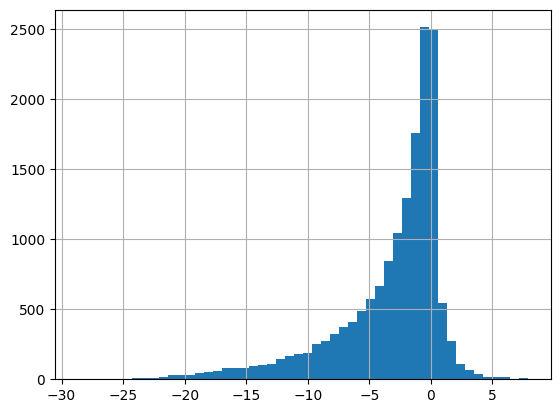

In [26]:
task_base['performance'].hist(bins=50)

***Remove colunas que não serão utilizadas***

In [27]:
task_base.columns

Index(['task_id', 'name', 'ends_at', 'actual_ends_at', 'delay', 'priority',
       'user_id', 'percentage', 'performance'],
      dtype='object')

In [28]:
task_base.drop(['task_id', 'name', 'ends_at', 'actual_ends_at', 'delay', 'percentage'], axis=1, inplace=True)

In [29]:
task_base

,priority,user_id,performance
0,3,user447,-0.46
1,3,user273,-1.96
2,3,user424,-1.38
3,3,user300,-1.78
4,3,user458,-0.36
...,...,...,...
15936,3,user467,-3.78
15937,3,user108,-8.26
15938,3,user229,-0.70
15939,3,user433,-12.88


***Faz media de performance por user***

In [30]:
new_base = pd.DataFrame(columns=['user_id', 'priority', 'performance'])
substitui_null = -100
for priority in range(5):
    for user in task_base['user_id'].unique():
        perf_list = task_base.loc[(task_base['user_id'] == user) & (task_base['priority'] == priority), 'performance']
        media = perf_list.mean()
        if len(perf_list) == 0:
            sum = 0
            for i in range(5):
                perf_list = task_base.loc[(task_base['user_id'] == user) & (task_base['priority'] == i), 'performance']
                if len(perf_list) == 0:
                    sum += 0
                else:
                    sum += perf_list.mean()
            media = sum/5
            
        
        new_base.loc[len(new_base)] ={'user_id': user, 'priority': priority, 'performance': media}


<Axes: >

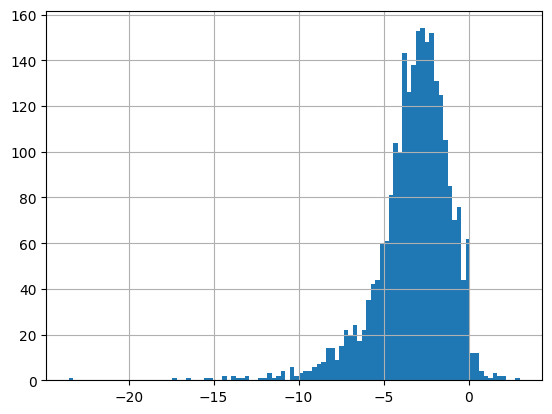

In [31]:
new_base['performance'].hist(bins=100)

In [32]:
new_base

,user_id,priority,performance
0,user447,0,-6.205000
1,user273,0,1.560000
2,user424,0,-0.450000
3,user300,0,-2.955000
4,user458,0,-1.120000
...,...,...,...
2495,user127,4,0.350000
2496,user316,4,-3.322500
2497,user443,4,-5.023333
2498,user93,4,-5.020000


In [33]:
new_base = new_base.sort_values(by=['user_id', 'priority'])

In [34]:
new_base.reset_index(drop=True, inplace=True)

In [35]:
new_base

,user_id,priority,performance
0,user0,0,-2.680000
1,user0,1,-0.635714
2,user0,2,-3.751000
3,user0,3,-3.467778
4,user0,4,-3.765000
...,...,...,...
2495,user99,0,-0.810000
2496,user99,1,-1.205000
2497,user99,2,-5.048571
2498,user99,3,-0.987273


In [76]:
n = 450
size = n
if size != -1:
    size *= 5
else:
    size = len(new_base)
new_base[0:size].to_csv(f'bases/final_base{n}.csv', index=False)

In [3]:
cu = pd.read_csv('bases/alocacao.csv')

In [7]:
len(set(cu['task_id']))

4000

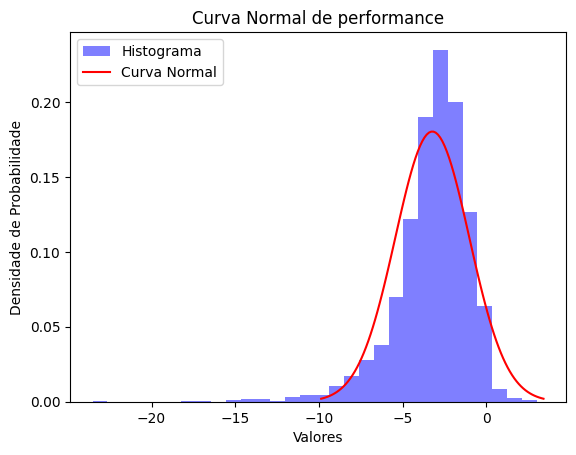

In [51]:
# Plota a curva normal de performance

# import matplotlib.pyplot as plt

# x = new_base['performance'].value_counts()
# y = new_base['performance'].value_counts()

# # plt.hist(new_base['performance'], bins=100)
# # plt.show()

# plt.plot(new_base['performance'].value_counts())

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm

# Calcule a média e o desvio padrão da coluna
media = new_base['performance'].mean()
desvio_padrao = new_base['performance'].std()

# Crie uma faixa de valores para o eixo x usando NumPy
x = np.linspace(media - 3 * desvio_padrao, media + 3 * desvio_padrao, 100)

# Calcule a função de densidade de probabilidade (PDF) da distribuição normal
pdf = norm.pdf(x, loc=media, scale=desvio_padrao)

# Plote o histograma dos dados
plt.hist(new_base['performance'], bins=30, density=True, alpha=0.5, color='blue', label='Histograma')

# Plote a curva normal usando a PDF calculada
plt.plot(x, pdf, color='red', label='Curva Normal')

# Adicione rótulos e uma legenda
plt.title('Curva Normal de performance')
plt.xlabel('Valores')
plt.ylabel('Densidade de Probabilidade')
plt.legend()

# Exiba o gráfico
plt.show()
